In [27]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

Keys in the file: ['archive', 'artiq_version', 'datasets', 'expid', 'rid', 'run_time', 'start_time']
<KeysViewHDF5 ['__param__VdP2mode', '__param__qubit', 'cal_count', 'cal_fit_signal', 'cal_freq', 'cal_motion_count', 'cal_motion_fit_signal', 'cal_motion_freq', 'cal_motion_pos', 'cal_pos', 'time', 'vib_freq']>
<KeysViewHDF5 []>
b'{"devarg_override": {}, "log_level": 30, "file": "VdP_Two_Ion/track_sideband_with_seq.py", "class_name": "track_sideband_with_seq", "arguments": {"DopplerCool_frequency_397_cooling": 212527272.72727272, "DopplerCool_frequency_866_cooling": 96666666.66666666, "DopplerCool_frequency_397_far_detuned": 220000000.0, "DopplerCool_attenuation_866": 13.0, "DopplerCool_attenuation_397_far_detuned": 18.0, "DopplerCool_doppler_cooling_cooling_time": 0.003, "DopplerCool_attenuation_397": 22.0, "SideBandCool2Mode_sideband2mode_att_729_dp": 13.0, "SideBandCool2Mode_sideband2mode_freq_729_sp": 82000000.0, "SideBandCool2Mode_sideband2mode_att_729_sp": 13.0, "SideBandCool2Mode

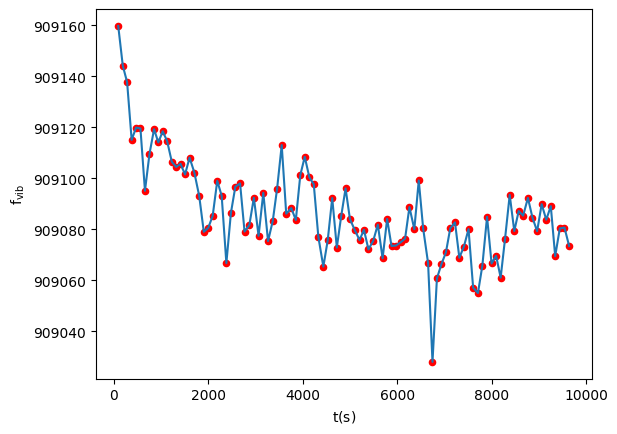

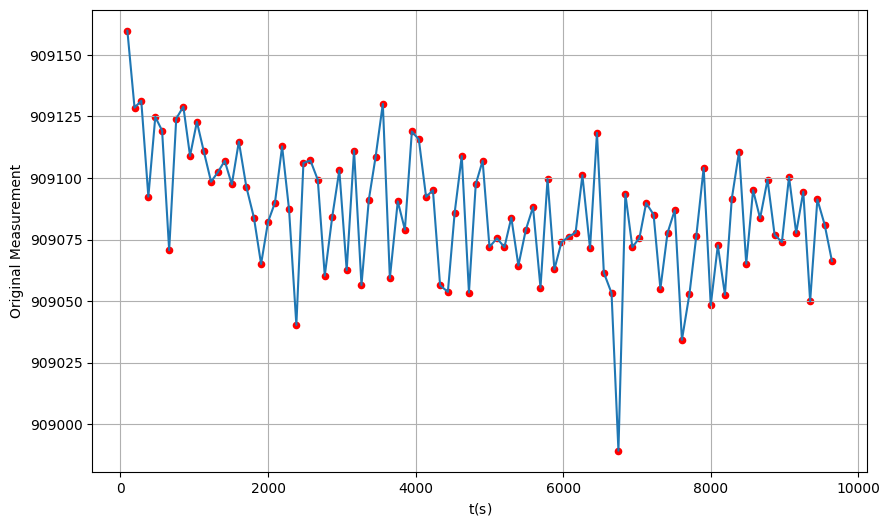

In [28]:
# Path to your .h5 file
file_path = './000071085-track_sideband_with_seq.h5'
#000044695-A6_VdP1mode_Wigner_AWG_Cam.h5'
#000043982-A6_Displacement_Wigner_AWG_Cam.h5'
#27408-A2_Displace_Wigner_2D.h5'
#4_Vdp_Wigner_2D.h5'
#-A2_Displace_Wigner_2D.h5'
#-A4_Vdp_Wigner_2D.h5'

# Open the .h5 file in read mode
with h5py.File(file_path, 'r') as file:
    # Print the names of the groups/datasets in the file
    print("Keys in the file:", list(file.keys()))
    
    # Assuming there's a dataset named 'data' in the file
    # Modify this part according to your file's structure
    data = file['datasets']
    print(file['datasets'].keys())

    print(file['archive'].keys())
    #print(file['archive']['__param__SDF'].keys())

    print(file['expid'][()])


    rabi_t= data['time'][:]
    pmt_count=data['vib_freq'][:]


# rabi_t= rabi_t[:len(rabi_t)//2]
# pmt_count=pmt_count[:len(pmt_count)//2]

plt.figure()
plt.plot(rabi_t, pmt_count)
plt.scatter(rabi_t, pmt_count,c='red',s=20)
plt.xlabel('${\\rm t(s)}$')
plt.ylabel('${\\rm f_{vib}}$')

# Recover original measurements from cumulative data
original_measurements = np.zeros_like(pmt_count)
original_measurements[0] = pmt_count[0]  # First point
for i in range(1, len(pmt_count)):
    original_measurements[i] = (pmt_count[i]*2 -  pmt_count[i-1])

# Plot original measurements
plt.figure(figsize=(10,6))
plt.plot(rabi_t, original_measurements)
plt.scatter(rabi_t, original_measurements, c='red', s=20)
plt.xlabel('${\\rm t(s)}$')
plt.ylabel('Original Measurement')
plt.grid(True)




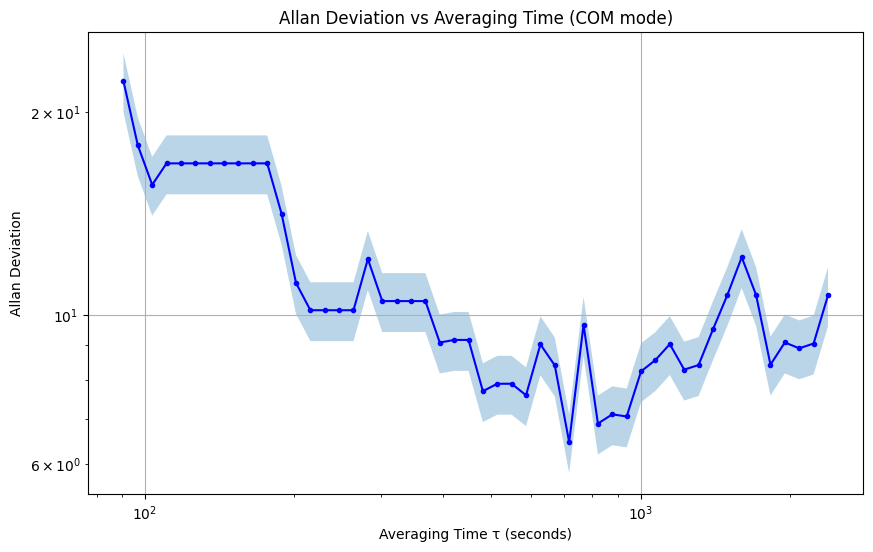

In [29]:
# Function to compute Allan deviation
def compute_allan_deviation(data, times, tau_values):
    """
    Compute Allan deviation for given data and tau values
    
    Parameters:
    data: array of frequency measurements
    times: array of measurement times
    tau_values: array of tau values (in seconds) to compute deviation for
    
    Returns:
    allan_dev: array of Allan deviation values corresponding to tau_values
    """
    allan_dev = []
    
    for tau in tau_values:
        # Find indices where time differences are closest to tau
        indices = []
        current_idx = 0
        while current_idx < len(times):
            next_idx = current_idx + 1
            while next_idx < len(times) and (times[next_idx] - times[current_idx]) < tau:
                next_idx += 1
            if next_idx < len(times):
                indices.append((current_idx, next_idx))
            current_idx = next_idx
            
        if len(indices) < 2:
            break
            
        # Compute averages for each tau interval
        averages = [np.mean(data[start:end]) for start, end in indices]
        
        # Compute Allan deviation
        differences = np.diff(averages)
        allan_var = np.sum(differences**2) / (2*(len(differences)))
        allan_dev.append(np.sqrt(allan_var))
        
    return np.array(allan_dev)

# Generate tau values (logarithmically spaced in seconds)
tau_min = np.min(np.diff(rabi_t))  # Minimum time difference
tau_max = (rabi_t[-1] - rabi_t[0])/4  # Using 1/4 of total time span
tau_values = np.logspace(np.log10(tau_min), np.log10(tau_max), 50)

# Compute Allan deviation
allan_dev = compute_allan_deviation(original_measurements, rabi_t, tau_values)

# Plot Allan deviation
plt.figure(figsize=(10, 6))
plt.loglog(tau_values, allan_dev, 'b.-')
plt.grid(True)
plt.xlabel('Averaging Time τ (seconds)')
plt.ylabel('Allan Deviation')
plt.title('Allan Deviation vs Averaging Time (COM mode)')

# Add error bars
# Assuming chi-squared distribution for error estimation
confidence = 0.68  # 1-sigma confidence
dof = 2 * (len(pmt_count) - 1)  # Degrees of freedom
err_bars = allan_dev * np.sqrt(2 / dof)

plt.fill_between(tau_values, 
                allan_dev - err_bars,
                allan_dev + err_bars,
                alpha=0.3)

plt.show()
